# VGG Image Classification Practical 
*By Andrea Vedaldi and Andrew Zisserman*

This is an [Oxford Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg) computer vision practical, authored by [Andrea Vedaldi](http://www.robots.ox.ac.uk/~vedaldi/) and Andrew Zisserman (Release 2018a).

<img style="width:100%" src="data/figures/cover.jpeg" alt="cover"/>

This practical is on image classification, where an image is classified according to its visual content. For example, does it contain an airplane or not. Important applications are image retrieval - searching through an image dataset to obtain (or retrieve) those images with particular visual content, and image annotation - adding tags to images if they contain particular object categories.

The goal of this session is to get basic practical experience with classification. It includes: (i) training a visual classifier for three different image classes (airplanes, motorbikes and people); (ii) assessing the performance of the classifier by computing a precision-recall curve; (iii) training set and testing set augmentation; and (iv) obtaining training data for new classifiers using Bing image search and using the classifiers to retrieve images from a dataset.

$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\bp}{\mathbf{p}}
\newcommand{\cP}{\mathcal{P}}
\newcommand{\cN}{\mathcal{N}}
\newcommand{\vv}{\operatorname{vec}}
$$

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 75

## Part 1: Training and testing an Image Classifier 

### Part 1.1: Data preparation

The data provided in the directory data consists of images and pre-computed descriptors for each image. The JPEG images are contained in data/images. The data consists of three image classes (containing airplanes, motorbikes or persons) and "background" images (i.e. images that do not contain these three classes). In the data preparation stage, this data is divided as:

| --     | aeroplane | motorbike | person | background |
|--------|-----------|-----------|--------|------------|
| train  | 112       | 120       | 1025   | 1019       |
| test   | 126       | 125       | 983    | 1077       |
| total  | 238       | 245       | 2008   | 2096       |

The images are listed in a number of text files; for example, files [`data/motorbike_train.txt`](data/motorbike_train.txt) and [`data/motorbike_val.txt`](data/motorbike_val.txt) list images that contain motorbikes. However, there is no need to access such files directly. The provided `lab` module contains various utility functions useful in this practical, including `lab.get_image_database()` for loading a "database" structure `imdb` with an index of these images. The following code demonstrates using this structure and the function `lab.get_indices()` in order to reproduce the table above. Note, in the following, we will use the val set as the test set.

> **Task:** Use the code below to load the image database structure and reproduce the table above.

> **Remark:** The same image may contain more than one class. Such images are counted multiple times in the table above.

In [3]:
import lab

imdb = lab.get_image_database()

total = 0
for class_name in ['aeroplane', 'motorbike', 'person', 'background']:
    for set_name in ['train', 'val']:
        indices = lab.get_indices(imdb, class_name, set_name)
        n = len(indices)
        total += n
        print(f"Number of {class_name} images for {set_name}: {n}")
print(f"Number of total examples: {total}")

Number of aeroplane images for train: 112
Number of aeroplane images for val: 126
Number of motorbike images for train: 120
Number of motorbike images for val: 125
Number of person images for train: 1025
Number of person images for val: 983
Number of background images for train: 1019
Number of background images for val: 1077
Number of total examples: 4587


An image is represented by a single vector descriptor. Mapping the visual content of an image to a single descriptor vector is often regarded as an encoding step, and the resulting descriptor is sometimes called a code. The main benefit of working with fixed length vectors is that they can be compared by simple vectorial metrics such as Euclidean distance. For the same reason, they are a natural representation to use in learning an image classifier.

We will use a *Convolutional Neural Network* (CNN) encoding. The process of constructing the CNN descriptor starting from an image is summarized next:

<img style="width:100%" src="data/figures/encoding.png" alt="cover"/>

First, the network is pre-trained on the ImageNet dataset to classify an image into one of a thousand categories. This determines all the parameters of the CNN, such as the weights of the convolutional filters. Then, for a new image, the trained network is used to generate a descriptor vector from the response of a layer in the architecture with this image as input. For this practical we will use the AlexNet network, which produces a 4096 dimensional descriptor vector at the last fully-connected layer before classification, called *fc7*. We also consider computationally cheaper but weaker features extracted from the convolutional layers. In particular, we consider the following **encodings**:

1. `conv3`: the third convolutional layer output, containing $2\times 2 \times 384$ feature channels.
2. `conv4`: the fourth convolutional layer output, containing $2\times 2 \times 256$ feature channels.
3. `conv5`: the fifth convolutional layer output, also containing $2\times 2 \times 256$ feature channels.
4. `fc7`: the last fully-connected layer output, containing 4096 feature channels.

The pre-computed codes can be computed by using the `lag.get_codes()` function.

> **Task:** Use the code below to load the feature vectors in a tensor `x`.

In [4]:
# Get the code vectors (for AlexNet layer conv3)
x = lab.get_codes(layer=3)

print(f"The tensor codes has size {list(x.shape)}")

The tensor codes has size [9892, 1536]


**Note:** The tensor `x` has one image code vector per row (when the CNN output is a 3D tensor, the latter is vectorized). There are more than 4587 (total number of images) rows as `x` contains code vectors for additional images, as discussed below in the data augmentation section.

### Part 1.2: Train a classifier for images containing motorbikes

We will start by training a classifier for images that contain motorbikes. The motorbike training images will be used as the positives, and the background images as negatives. The classifier is a linear Support Vector Machine (SVM).

> **Tasks:**
> * Use the code below to display some images in the database.
> * Look through example images of the motorbike class and the background images by changing the code as needed.

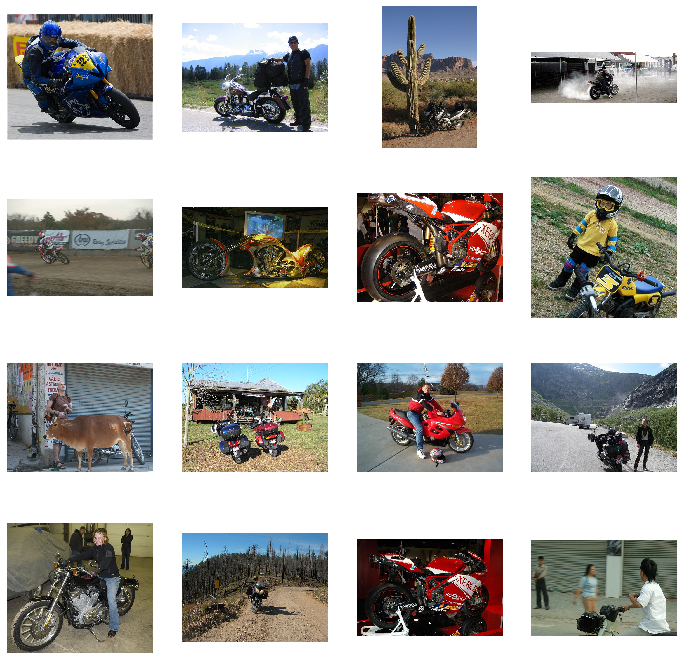

In [5]:
# Show some training images
c = imdb['class_names'].index('motorbike')
s = imdb['set_names'].index('train')
indices = lab.get_indices(imdb, c, s)
indices = indices[:16]

from matplotlib import pyplot as plt

plt.figure(figsize=(12,12))
for t, index in enumerate(indices):
    image = lab.get_image(imdb, index)
    plt.gcf().add_subplot(4,4,t+1)
    lab.imsc(image[0])

Before training an SVM, it is usually a good idea to normalize the data. Here we simply make all vectors have unit norm.

> **Task:** Run the code below to normalize the code vectors in the tensor `x`.

In [6]:
import torch

# Normalize the code vectors
x /= torch.sqrt((x * x).sum(1))[:,None]

Before we can train the model, we must select an appropriate set of positive training and validation images. For that, we use the provided `lab.get_indices()` functions. The positive images are motorbike images in the training set. The negative images are aeroplane, person, and background images in the training set, minus any positive image (this is required as the same image can contain multiple classes).

> **Task:** Run the code below to get the indices of the positive and negative training images. For now use only 20 positive training images, as indicated.

In [7]:
# Get the training images
pos_train = lab.get_indices(imdb, 'motorbike',  'train')
neg_train = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train', minus=pos_train)

# Limit the training set size
pos_train = pos_train[:20]
neg_train = neg_train[:]

We are now ready to run the support vector machine optimizer. For that, we use the *stochastic dual coordinate ascent (SDCA)* algorithm which produces an upper and lower bound on the classifier objective function and can thus detect convergence automatically.

> **Task:** Run the code below to train the SVM.

Train an SVM using 20 positive, 2059 negative examples, and regularization 0.0001.
SDCA epoch:  0 lower bound: 0.003 upper bound: 0.019
SDCA epoch:  10 lower bound: 0.013 upper bound: 0.020
SDCA epoch:  20 lower bound: 0.013 upper bound: 0.014
SDCA epoch:  24 lower bound: 0.013 upper bound: 0.013


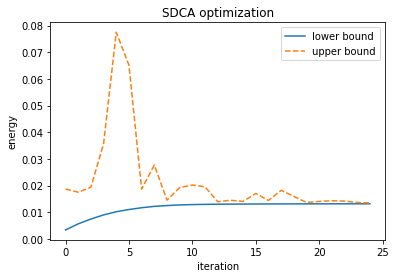

In [8]:
def get_scores(w, b, x):
    return x @ w + b

def train(x, pos, neg, lam=1e-4):
    print(f"Train an SVM using {len(pos)} positive, {len(neg)} negative examples, and regularization {lam}.")

    # Extract training codes and labels
    x_train = x[torch.cat((pos, neg))]
    c_train = torch.tensor([1] * len(pos) + [-1] * len(neg), dtype=torch.float32)

    # Train the SVM using the SDCA solver
    w, b = lab.svm_sdca(x_train, c_train, lam=lam)
    
    # Get the training data scores
    scores_train = get_scores(w, b, x_train)    
    return w, b, c_train, scores_train
    
w, b, c_train, scores_train = train(x, pos_train, neg_train)

We will first assess qualitatively how well the classifier works by using it to rank all the training images.

> **Question:** What do you expect to happen? 

> **Task:** Use the code below to show the ranked list using the provided function `lab.plot_ranked_list()`.

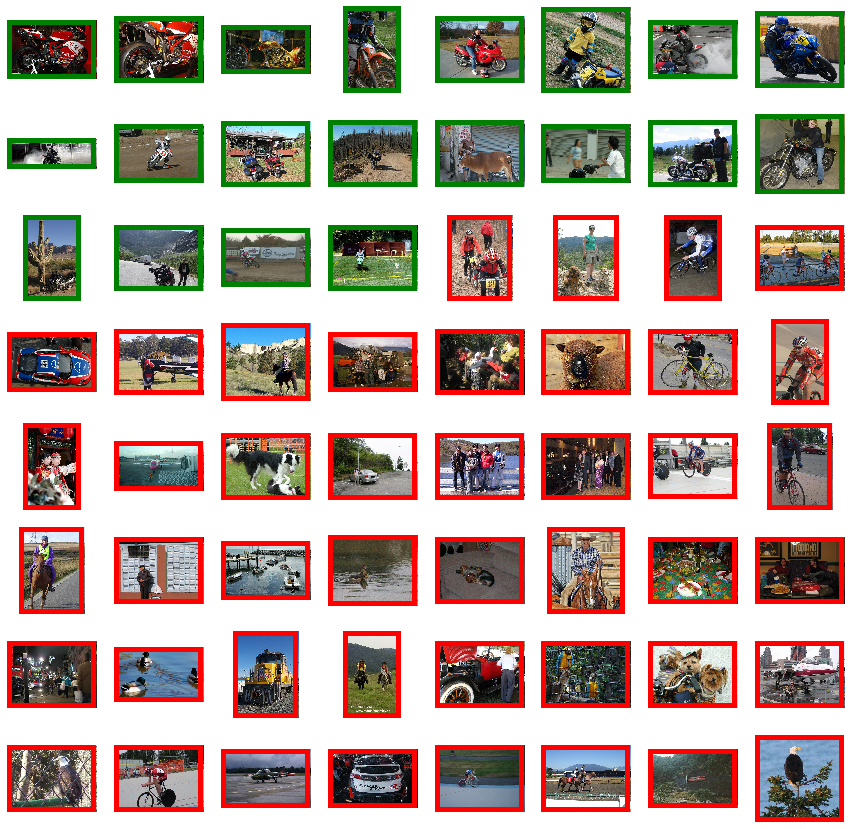

In [9]:
# Sort images by decreasing scores
_, perm = torch.sort(scores_train, descending=True)

# Show ranked 
plt.figure(1, figsize=(15,15))
lab.plot_ranked_list(imdb, pos_train, neg_train, perm)

### Part 1.3: Classify the test images and assess the performance

Now apply the learnt classifier to the test images. Again, you can look at the qualitative performance by using the classifier score to rank all the test images. Note the bias term is not needed for this ranking, only the classification vector `w`.

> **Question:** Why is the bias term not needed?

> **Task:** Use the code below to evaluate the SVM on the validation data and plot the corresponding ranked list of images.

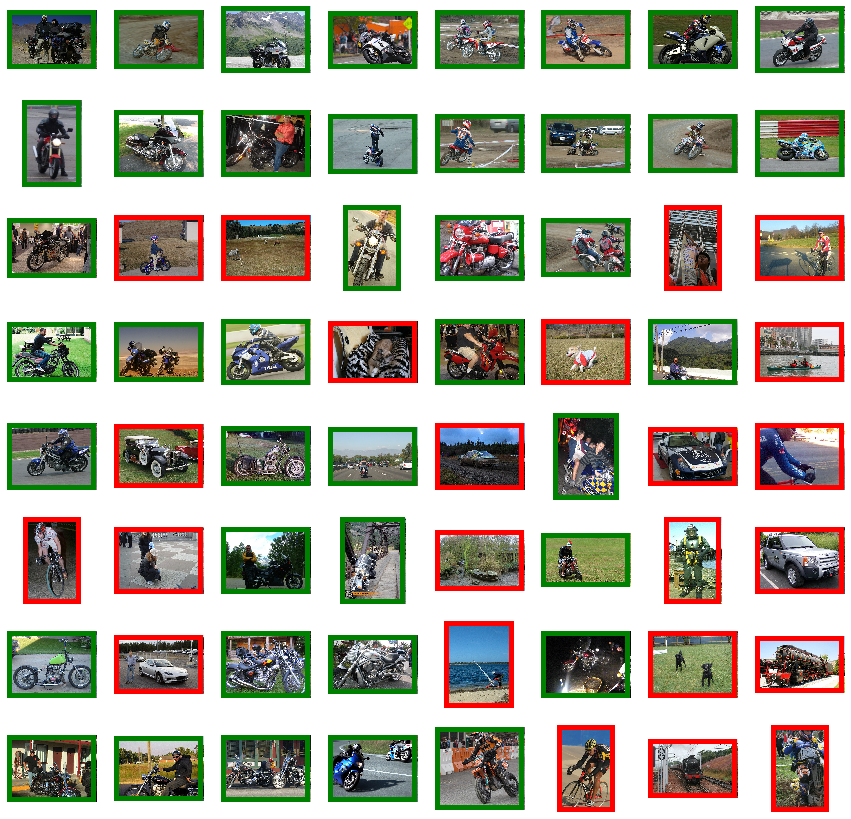

In [10]:
# Get the validation images
pos_val = lab.get_indices(imdb, 'motorbike',  'val')
neg_val = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'val', minus=pos_val)

# Extract the validation codes
x_val = x[torch.cat((pos_val, neg_val))]

# Compute the validation scores
scores_val = get_scores(w, b, x_val)

# Sort images by decreasing scores
_, perm_val = torch.sort(scores_val, descending=True)

# Show ranked images
plt.figure(1, figsize=(15,15))
lab.plot_ranked_list(imdb, pos_val, neg_val, perm_val)

Now we will measure the retrieval performance quantitatively by computing a Precision-Recall curve. Recall the definitions of **precision** and **recall**:

<img style="height:15em" src="data/figures/pr1.png" alt="pr1"/>

The *precision-recall* (PR) curve is computed by varying the threshold on the classifier (from high to low) and plotting the values of precision against recall for each threshold value. In order to assess the retrieval performance by a single number (rather than a curve), the *Average Precision* (AP, the area under the curve) is often computed. Make sure you understand how the precision values in the Precision-Recall curve correspond to the ranking of the positives and negatives in the retrieved results.

> **Task:** Run the code below to view the precision-recall curves using the provided function `lab.pr()`.

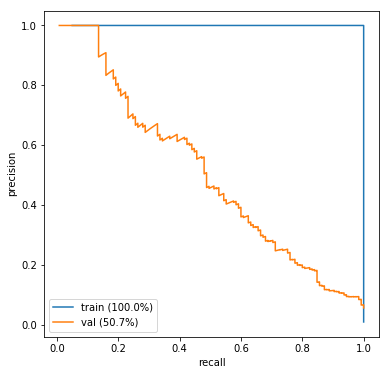

In [11]:
# Compute the validation labels
c_val = torch.cat((torch.ones(len(pos_val)), -torch.ones(len(neg_val))))

# Compute the precision-recall curves
plt.figure(figsize=(6,6))
_, _, ap_train = lab.pr(c_train, scores_train)
_, _, ap_val = lab.pr(c_val, scores_val)
plt.legend((f'train ({100*ap_train:.1f}%)', f'val ({100*ap_val:.1f}%)')) ;

### Part 1.4: Increase the number of training images

So far we have used only 20 (of the 120) positive images for training the classifier.

> **Task:** Use the code below to retrain the SVM after changing the number of training images, particularly for the positive images, and measure the effect.

> **Questions:** 
> 
>   * How much does the performance vary as `numPos` is changed from 1 to `+inf` (indicating that all available positive images are used)?
>   * Compare doubling the number of training images by either including fresh samples or generating new samples using augmentation. Which performs better? Why?

Train an SVM using 120 positive, 2059 negative examples, and regularization 0.0001.
SDCA epoch:  0 lower bound: 0.015 upper bound: 0.097
SDCA epoch:  10 lower bound: 0.057 upper bound: 0.067
SDCA epoch:  20 lower bound: 0.060 upper bound: 0.068
SDCA epoch:  30 lower bound: 0.061 upper bound: 0.064
SDCA epoch:  40 lower bound: 0.061 upper bound: 0.062
SDCA epoch:  46 lower bound: 0.061 upper bound: 0.062


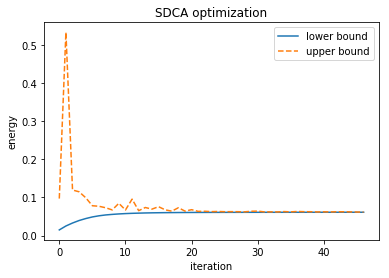

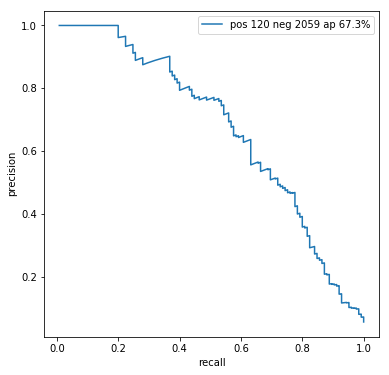

In [12]:
# Get the training images
pos_train = lab.get_indices(imdb, 'motorbike',  'train')
neg_train = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train', minus=pos_train)

# Limit the training set size
pos_train = pos_train[:]
neg_train = neg_train[:]

# Train the SVM
w, b, _, _ = train(x, pos_train, neg_train)

# Evalaute the SVM
scores_val = get_scores(w, b, x_val)

plt.figure(figsize=(6,6))
_, _, ap_val = lab.pr(c_val, scores_val)
message = f'pos {len(pos_train)} neg {len(neg_train)} ap {100*ap_val:.1f}%'
plt.legend((message,)) ;

 ### Part 1.5: Increase the number of training images by data augmentation

Up to this point the descriptor vector has been computed from the image as is. We now consider representing each image multiple times by generating a descriptor for both the original image and for the image after `flipping' (a mirror reflectance about a vertical axis). This data augmentation will be used in a different manner at training and test time. In training, the descriptors from the flipped images will be used as additional training samples (i.e. each original image generates two data samples for training). In testing, the descriptors for the original and flipped image will be averaged resulting in, again, a single vector representing the test image.

> **Task:** Use the code below to retrain the SVM including the training and test augmentation and evaluate it.

Train an SVM using 120 positive, 2059 negative examples, and regularization 0.0001.
SDCA epoch:  0 lower bound: 0.015 upper bound: 0.094
SDCA epoch:  10 lower bound: 0.058 upper bound: 0.095
SDCA epoch:  20 lower bound: 0.060 upper bound: 0.065
SDCA epoch:  30 lower bound: 0.061 upper bound: 0.066
SDCA epoch:  40 lower bound: 0.061 upper bound: 0.062
SDCA epoch:  49 lower bound: 0.061 upper bound: 0.061


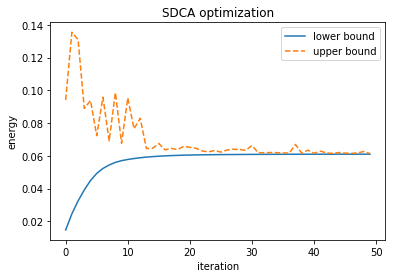

Train an SVM using 240 positive, 4118 negative examples, and regularization 0.0001.
SDCA epoch:  0 lower bound: 0.025 upper bound: 0.096
SDCA epoch:  10 lower bound: 0.070 upper bound: 0.073
SDCA epoch:  20 lower bound: 0.071 upper bound: 0.072
SDCA epoch:  29 lower bound: 0.071 upper bound: 0.071


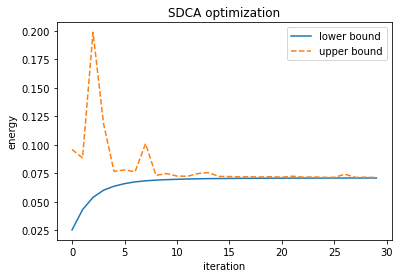

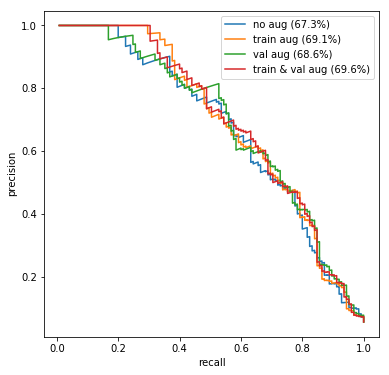

In [13]:
# Get and normalize the code vectors
x = lab.get_codes(layer=3)
x /= torch.sqrt((x * x).sum(1))[:,None]

# Train with normal images together, as before
pos_train = lab.get_indices(imdb, 'motorbike',  'train', jitters=['normal'])
neg_train = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train',
                            jitters=['normal'], minus=pos_train)
w, b, _, _ = train(x, pos_train, neg_train)

# Retrain with normal and jitter images together
pos_train_aug = lab.get_indices(imdb, 'motorbike',  'train', jitters=['normal', 'flipped'])
neg_train_aug = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train',
                                jitters=['normal', 'flipped'], minus=pos_train_aug)
w_aug, b_aug, _, _ = train(x, pos_train_aug, neg_train_aug)

# Get the normal version of the validation images
pos_val = lab.get_indices(imdb, 'motorbike',  'val')
neg_val = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'val', minus=pos_val)
x_val = x[torch.cat((pos_val, neg_val))]

# Get the jittered version of the validation images
pos_val_jit = lab.get_indices(imdb, 'motorbike', 'val', jitters=['flipped'])
neg_val_jit = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'val',
                              jitters=['flipped'], minus=pos_val_jit)
x_val_jit = x[torch.cat((pos_val_jit, neg_val_jit))]

# Evaluate the model trained without and with jitter using validation data without and with jitter
scores_val               = get_scores(w, b, x_val)
scores_train_aug_val     = get_scores(w_aug, b_aug, x_val)
scores_val_aug           = get_scores(w, b, x_val_jit) + scores_val
scores_train_aug_val_aug = get_scores(w_aug, b_aug, x_val_jit) + scores_train_aug_val

# Compute the precision-recall curves
plt.figure(figsize=(6,6))
_, _, ap_val               = lab.pr(c_val, scores_val)
_, _, ap_train_aug_val     = lab.pr(c_val, scores_train_aug_val)
_, _, ap_val_aug           = lab.pr(c_val, scores_val_aug)
_, _, ap_train_aug_val_aug = lab.pr(c_val, scores_train_aug_val_aug)

plt.legend((f'no aug ({100*ap_val:.1f}%)', 
            f'train aug ({100*ap_train_aug_val:.1f}%)',
            f'val aug ({100*ap_val_aug:.1f}%)',
            f'train & val aug ({100*ap_train_aug_val_aug:.1f}%)',
           )) ;

Note, the change in classification performance if: (i) only training data augmentation is used, (ii) only testing data augmentation is used; and (iii) both training and test data are augmented.

> **Questions:**
> 
> * Is classifying the average vector for the test image the same as classifying each vector independently and then averaging the classifier score?
> * When would you expect flipping augmentation to be detrimental to performance?
> * How could additional descriptors be obtained from each image?

**Note:** when learning the SVM, to save training time we are not changing the $\lambda$ parameter controlling the regularization strength. This parameter influences the generalization error and should be relearnt on a validation set when the training setting is changed. However, in this case the influence of $\lambda$ is small as can be verified experimentally (see the next [section](#stage1f)).

<a name=stage1f></a>
### Part 1.6: Setting the hyper-parameter lambda of the SVM

If there is a significant difference between the training and test performance, then that indicates over fitting. The difference can often be reduced, and the test performance (generalization), improved by changing the SVM $\lambda$ parameter. 

> **Task:** Use the code below to vary the $\lambda$ parameter in the range 1 to 1e-5 (the default is $\lambda$=1e-4), and plot the AP on the training and test data as $\lambda$ varies.

> **Question:** How do validation performance and training time vary as $\lambda$ is changed?

Train an SVM using 120 positive, 2059 negative examples, and regularization 0.001.
SDCA epoch:  0 lower bound: 0.088 upper bound: 0.125
SDCA epoch:  10 lower bound: 0.104 upper bound: 0.105
SDCA epoch:  13 lower bound: 0.104 upper bound: 0.105


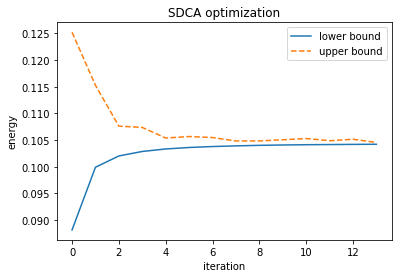

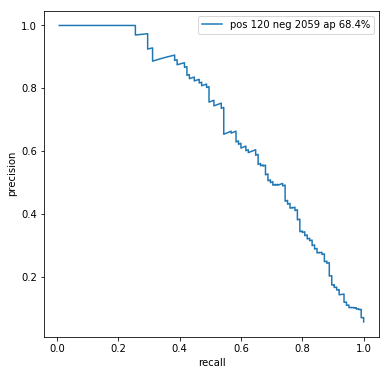

In [14]:
# Get the training images
pos_train = lab.get_indices(imdb, 'motorbike',  'train')
neg_train = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train', minus=pos_train)

# Train the SVM
w, b, _, _ = train(x, pos_train, neg_train, lam=0.001)

# Evaluate the SVM
scores_val = get_scores(w, b, x_val)
plt.figure(figsize=(6,6))
_, _, ap_val = lab.pr(c_val, scores_val)
message = f'pos {len(pos_train)} neg {len(neg_train)} ap {100*ap_val:.1f}%'
plt.legend((message,)) ;

**Note:** hyper-parameters and performance should actually be assessed on a validation set that is held out from the training set. They should not be assessed on the test set. In this practical we are not enforcing this good practice, but don't optimize on the test set once you move on from this practical and start to classify your own data.

### Part 1.7: Learn a classifier for the other categories and assess its performance

*Skip [below](#stage1h) on fast track*

> **Task:** Use the code below to train two object categories: aeroplane and people. In each case record the AP performance measure.

> **Question:** Does the AP performance match your expectations based on the variation of the class images?

Train an SVM using 112 positive, 2067 negative examples, and regularization 0.0001.
SDCA epoch:  0 lower bound: 0.010 upper bound: 0.072
SDCA epoch:  10 lower bound: 0.035 upper bound: 0.042
SDCA epoch:  20 lower bound: 0.036 upper bound: 0.041
SDCA epoch:  30 lower bound: 0.036 upper bound: 0.037
SDCA epoch:  37 lower bound: 0.037 upper bound: 0.037


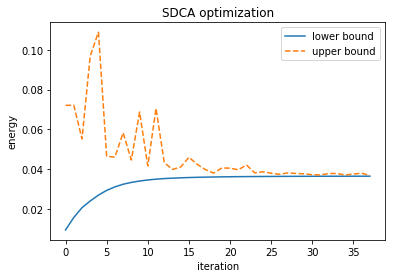

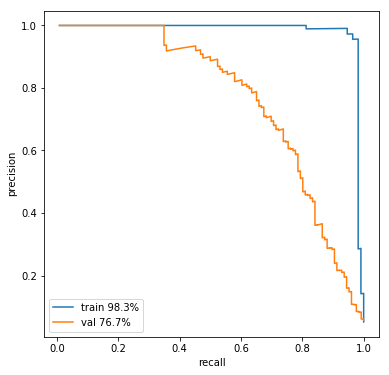

In [15]:
# Get the training images and train the SVM
pos_train = lab.get_indices(imdb, 'aeroplane',  'train')
neg_train = lab.get_indices(imdb, ['motorbike', 'person', 'background'], 'train', minus=pos_train)
w, b, c_train, scores_train = train(x, pos_train, neg_train)

# Get the validation images and labels
pos_val = lab.get_indices(imdb, 'aeroplane',  'val')
neg_val = lab.get_indices(imdb, ['motorbike', 'person', 'background'], 'val', minus=pos_val)
x_val = x[torch.cat((pos_val, neg_val))]
c_val = torch.cat((torch.ones(len(pos_val)), -torch.ones(len(neg_val))))

# Evaluate the SVM
scores_val = get_scores(w, b, x_val)
plt.figure(figsize=(6,6))
_, _, ap_train = lab.pr(c_train, scores_train)
_, _, ap_val = lab.pr(c_val, scores_val)
plt.legend((f'train {100*ap_train:.1f}%', f'val {100*ap_val:.1f}%')) ;

<a name=stage1h></a>
### Part 1.8 :Vary the image representation

An important practical aspect of image descriptors is their normalization. For example, if we regard the CNN descriptor as a discrete probability distribution it would seem natural that its elements should sum to 1. This is the same as normalizing the descriptor vectors in the L1 norm. However, above L2 normalization (sum of squares) is used instead.

> **Task:** Use the following code to experiment with L1 normalization and no normalization and measure the performance change.

Train an SVM using 20 positive, 2059 negative examples, and regularization 0.0001.
SDCA epoch:  0 lower bound: 0.000 upper bound: 0.014
SDCA epoch:  10 lower bound: 0.000 upper bound: 0.002
SDCA epoch:  16 lower bound: 0.000 upper bound: 0.000


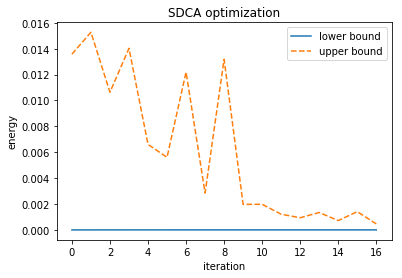

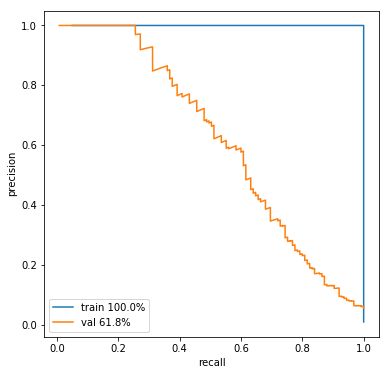

In [16]:
layer = 5
num_pos = 20

# Get the code vectors and normalize them
x = lab.get_codes(layer=layer)
#x /= torch.sqrt((x * x).sum(1))[:,None]
#x /= torch.abs(x).sum(1)[:,None]

# Get the training images and train the SVM
pos_train = lab.get_indices(imdb, 'motorbike', 'train')
neg_train = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train', minus=pos_train)
pos_train = pos_train[:num_pos]
w, b, c_train, scores_train = train(x, pos_train, neg_train)

# Get the validation images and labels
pos_val = lab.get_indices(imdb, 'motorbike', 'val')
neg_val = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'val', minus=pos_val)
x_val = x[torch.cat((pos_val, neg_val))]
c_val = torch.cat((torch.ones(len(pos_val)), -torch.ones(len(neg_val))))

# Evaluate the SVM
scores_val = get_scores(w, b, x_val)
plt.figure(figsize=(6,6))
_, _, ap_train = lab.pr(c_train, scores_train)
_, _, ap_val = lab.pr(c_val, scores_val)
plt.legend((f'train {100*ap_train:.1f}%', f'val {100*ap_val:.1f}%')) ;

A linear SVM can be thought of as using a linear kernel
$$
 K(\mathbf{h},\mathbf{h}') = \sum_{i=1}^d h_i h'_i
$$
to measure the similarity between pair of objects $h$ and $h'$ (in this case pairs of CNN descriptors).

> **Question:** What can you say about the self-similarity,$K(\mathbf{h},\mathbf{h})$, of a descriptor $\mathbf{h}$ that is L2 normalized?

Compare $K(\mathbf{h},\mathbf{h})$ to the similarity, $K(\mathbf{h},\mathbf{h}')$,of two different L2 normalized descriptors $\mathbf{h}$ and $\mathbf{h}'$

> **Questions:**
> * Can you say the same for unnormalized or L1 normalized descriptors?
> * Do you see a relation between the classification performance and L2 normalization?

A useful rule of thumb is that better performance is obtained if the vectors that are ultimately fed to a linear SVM (after any intermediate processing) are L2 normalized.

### Part 1.9: Vary the CNN representation

The CNN image features are very strong because they are pretrained on millions of images from the ImageNet data. So far, we have experimented with the `conv5` features. Try now to extract features from a different layer in the architecture and observe how the performance changes:

> **Tasks**:
>
> * Restore L2 normalization for the image representation (see the previous stage) and choose a category.
> * Rerun classification using only 10 training images by and pick code vectors from `conv1`, `conv2`, `conv3`, `conv4`, `conv5`, `fc6` and `fc7`.
> * Note the resulting performance.

> **Question:** How much does the choice of feature depth affect classification performance?

Now make the setup even more extreme by considering the so-called one-shot learning problem, i.e. learning an image classifier from a single training image. Thus, set `pos_train` to one element and rerun the experiments.

> **Questions:**
> 
> * Can you get good performance using a single training images and the deeper features?
> * If so, how is it possible that the system can learn to recognize an object from a single example?

### Part 1.10: Visualize class saliency


You can use the function `lab.plot_saliency()` to visualize the areas of the image that the classifier thinks are most related to the class . Use this function first to visualize the class saliency using `fc7` features for an image containing the object category (adjust and rerun the cell above to train the corresponding model if needed).

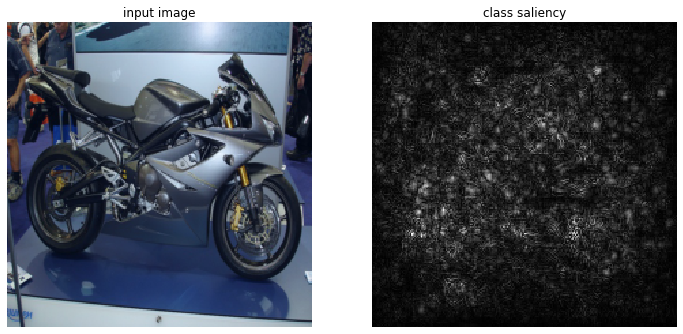

In [17]:
# Get a positive validation image as a PIL image
im_pil = lab.get_pil_image(imdb, pos_val[4])

# Get the encoder neural network and normalize the image accordingly
model = lab.get_encoder_cnn()
im = model.normalize(im_pil)

# Plot the saliency
plt.figure(1, figsize=(12,12))
lab.plot_saliency(model, layer, w, im)

> **Question:** Do the areas correspond to the regions that you would expect to be selected?

*Skip to [Part 2](#part2) on fast track*

> **Tasks**:
>
> * Visualize the class saliency using features from other layers, `conv1` to `fc7`.
> * Rerun the visualizations for an image not containing the object category.

<a name=part2></a>
## Part 2: Training an Image Classifier for Retrieval using Internet images

In Part 1 of this practical the training data was provided and all the feature vectors pre-computed. The goal of this second part is to choose the training data yourself in order to optimize the classifier performance. The task is the following: you are given a large corpus of images and asked to retrieve images of a certain class, e.g. those containing a bicycle. You then need to obtain training images, e.g. using Google Image Search, in order to train a classifier for images containing bicycles and optimize its retrieval performance.

The code below provides the following functionality: it loads a number of image URLs from the internet and computes their code vectors. It then uses negative examples from the image database used above to train a classifier and rank the test images. To get started, we will train a classifier for *horses*.

> **Task:** Modify the code below to load a certain number of images of horses from the internet. Google Image Search, Bing, or Wikimedia Commons are all good sources.

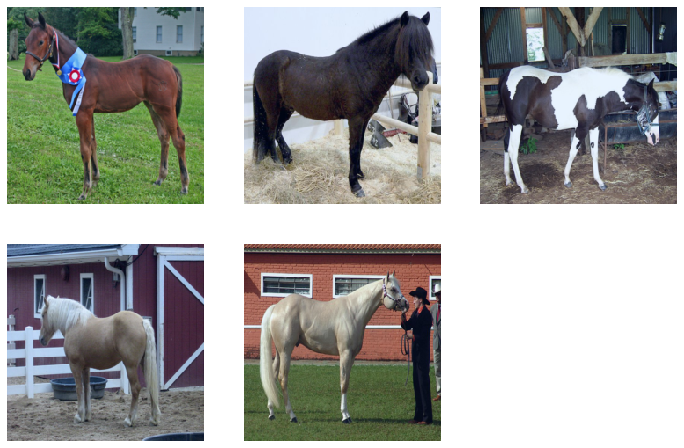

In [18]:
# Load some images from the Internet and compute their code vectors
cache = lab.ImageCache()
cache.add('https://upload.wikimedia.org/wikipedia/commons/a/ab/Rock%27s-anne-supreme-winner.jpg')
cache.add('https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Aegidienberger.jpg/528px-Aegidienberger.jpg')
cache.add('https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/New_Moon_Girl_%28Little_Girl%29_Spanish_Mustang_Mare.jpg/640px-New_Moon_Girl_%28Little_Girl%29_Spanish_Mustang_Mare.jpg')
cache.add('https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Draft_horse.jpg/640px-Draft_horse.jpg')
cache.add('https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Quarter_Horse%28REFON%29-cleaned.jpg/640px-Quarter_Horse%28REFON%29-cleaned.jpg')

plt.figure(1, figsize=(12,8))
cache.plot()

Next, the positive code vectors for the images just downloaded are added to the negative code vectors from the image database and an SVM is trained.

> **Task:** Run the code below to train the SVM.

SDCA epoch:  0 lower bound: 0.001 upper bound: 0.009
SDCA epoch:  9 lower bound: 0.002 upper bound: 0.003


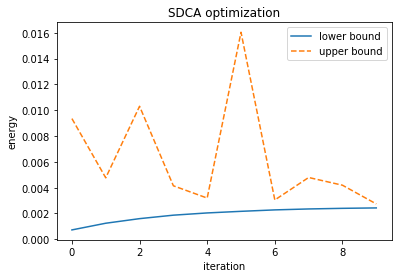

In [19]:
# Get training data
layer = 5

# Get the code vectors and normalize them
x_new = cache.get_codes(layer=layer)
x_new /= torch.sqrt((x_new * x_new).sum(1))[:,None]

x = lab.get_codes(layer=layer)
x /= torch.sqrt((x * x).sum(1))[:,None]

# Assemble training set using database images as negative examples
neg_train = lab.get_indices(imdb, ['aeroplane', 'person', 'background'], 'train', minus=pos_train)
x_train = torch.cat((x_new, x[neg_train]),0)
c_train = torch.tensor([1] * len(cache) + [-1] * len(neg_train), dtype=torch.float32)

# Train the SVM using the SDCA solver
w, b = lab.svm_sdca(x_train, c_train, lam=1e-4)

# Get the training data scores
scores_train = get_scores(w, b, x_train)

Now that the classifier is trained we can assess it on a validation set. Fortunately `imdb` contains images for 148 validation images for the class *horse*, so we can use it as above. Your goal is to train a classifier that can retrieve as many of these as possible in a high ranked position. You can measure your success by looking at the average precision of the classifier on the validation set, as before.

> **Task:** Run the code below to assess your newly-trained SVM.

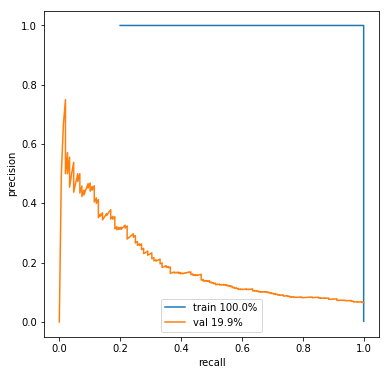

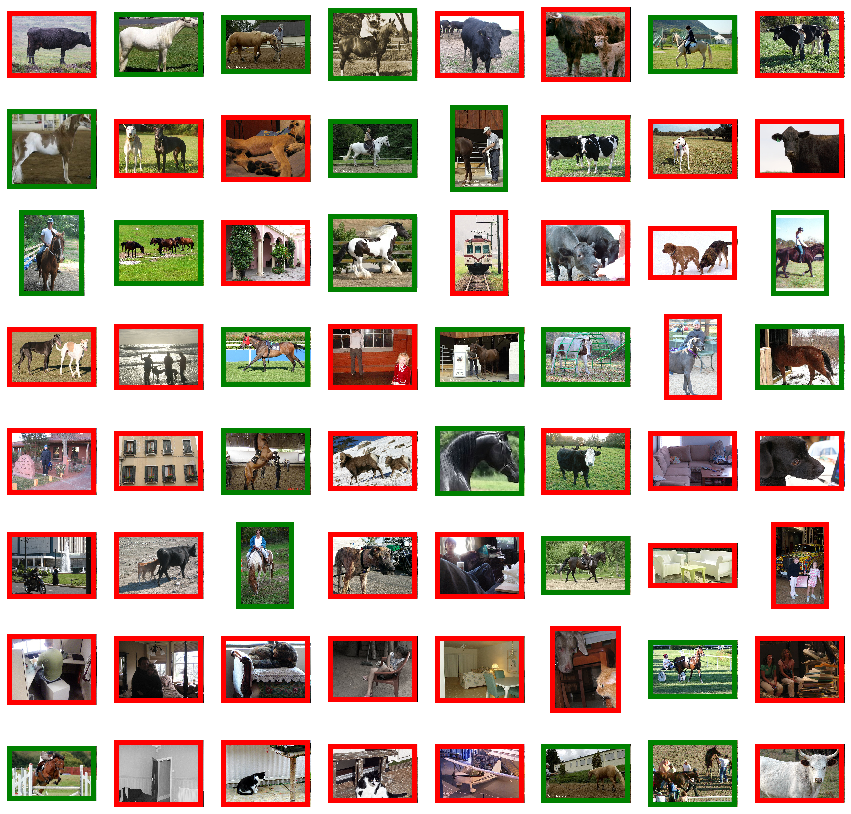

In [20]:
# Get the validation images and labels
pos_val = lab.get_indices(imdb, 'horse', 'val')
neg_val = lab.get_indices(imdb, ['aeroplane', 'motorbike', 'person', 'background'], 'val', minus=pos_val)
x_val = x[torch.cat((pos_val, neg_val))]
c_val = torch.cat((torch.ones(len(pos_val)), -torch.ones(len(neg_val))))

# Evaluate the SVM on the validation data
scores_val = get_scores(w, b, x_val)

# Precision-recall curves
plt.figure(1, figsize=(6,6))
_, _, ap_train = lab.pr(c_train, scores_train)
_, _, ap_val = lab.pr(c_val, scores_val)
plt.legend((f'train {100*ap_train:.1f}%', f'val {100*ap_val:.1f}%')) ;

# Ranked image list
_, perm = torch.sort(scores_val, descending=True)
plt.figure(2, figsize=(15,15))

lab.plot_ranked_list(imdb, pos_val, neg_val, perm) ;

Here are some ways to improve the classifier:

> **Tasks:**
> * Add more positive training images.
> * Add more positive training images, but choose these to be varied from those you already have.
> * The validation data also contains the category car. Train classifiers for it and compare the difficulty of this and the horse class.

## Links and further work

* The code for this practical is written using the PyTorch library, which is freely available as source code and binary.
* The images for this practical are taken from the [PASCAL VOC 2007 benchmark](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/).
* For a tutorial on large scale image classification and references to the literature, see [here](https://sites.google.com/site/lsvr13/).

## Acknowledgements

* Funding from ERC grant "Integrated and Detailed Image Understanding", and the EPSRC Programme Grant "SeeBiByte".

<img style="height:100px" src="data/figures/erc.jpg" alt="erc" />
<img style="height:50px" src="data/figures/epsrc.png" alt="epsrc" />

## History

* Used in the Oxford AIMS CDT, 2018-19 (PyTorch).
* Used in the Oxford AIMS CDT, 2017-18.
* Used in the Oxford AIMS CDT, 2016-17.
* First used in the Oxford AIMS CDT, 2015-16.
* Replaces the Image Categorization practical based on hand-crafted features.